# Training and evaluation:
## Source: https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets

In [ ]:
import os
import random
from typing import List, Dict, Any
from torchvision.ops import nms, box_iou
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms
import torch
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import kagglehub


In [9]:
path = kagglehub.dataset_download("davidbroberts/brain-tumor-object-detection-datasets")
print("Path to dataset files:", path)

raw_data_directory = path
print(os.listdir(raw_data_directory)[:10])


Using Colab cache for faster access to the 'brain-tumor-object-detection-datasets' dataset.
Path to dataset files: /kaggle/input/brain-tumor-object-detection-datasets
['coronal_t1wce_2_class', 'axial_t1wce_2_class', 'sagittal_t1wce_2_class']


In [10]:
def get_data(dataset_part ="train/", plane = "axial/"):
    root_directory = raw_data_directory + plane
    annotations_dir = root_directory + "labels/" + dataset_part
    images_dir = root_directory + "images/" + dataset_part

    dataset = []

    for filename in os.listdir(annotations_dir):
        if not filename.endswith(".txt"):
            continue

        file_path = os.path.join(annotations_dir, filename)
        image_name = os.path.splitext(filename)[0] + ".jpg"
        image_path = os.path.join(images_dir, image_name)

        labels = []
        bboxes = []

        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                label = int(parts[0])
                bbox = [float(x) for x in parts[1:]]  # [x_center, y_center, width, height]

                labels.append(label)
                bboxes.append(bbox)

        dataset.append({
            "image_path": image_path,
            "labels": labels,
            "bboxes": bboxes
        })
    return dataset


In [11]:
plane = "/axial_t1wce_2_class/"

training_dataset = get_data("train/", plane)
test_dataset = get_data("test/", plane)

# Continuation: Tumor Object Detection (TorchVision Faster R-CNN)
The cells below continue the existing notebook **without modifying the beginning**. They:
- Wrap your `training_dataset` / `test_dataset` records into a proper PyTorch `Dataset` for detection,
- Build a **Faster R-CNN ResNet50 FPN** model (pretrained on COCO) with 3 classes: background, `MGMT-`, `MGMT+`,
- Train (optionally) and evaluate, with COCO-style metrics if available, otherwise a simple PR/F1 at IoU=0.5,
- Provide a visualization helper.

> Assumptions: each record looks like `{'image_path': str, 'labels': List[int], 'bboxes': List[List[float]]}`
with YOLO-style normalized boxes `(x_center, y_center, width, height)`.


In [15]:
# Setup (device, imports, reproducibility)

def collate_fn(batch):
    return tuple(zip(*batch)) if not HAVE_TV_REFS else getattr(utils, 'collate_fn', lambda b: tuple(zip(*b)))(batch)

SEED = 123
random.seed(SEED)
torch.manual_seed(SEED)

# Prefer accelerator if available
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device('cpu')
print('Using device:', device)

# Class names: index 0 is background; dataset labels {0,1} are remapped to {1,2}
CLASS_NAMES = ['__background__', 'MGMT-', 'MGMT+']
NUM_CLASSES = 3

if 'get_transform' not in globals():
    def get_transform(train: bool):
        ts = []
        if train:
            ts.append(T.RandomHorizontalFlip(0.5))
        ts.append(T.ToDtype(torch.float, scale=True))
        ts.append(T.ToPureTensor())
        return T.Compose(ts)

def _yolo_to_xyxy(box, w, h):
    # box = (x_center, y_center, width, height) in normalized [0,1]
    xc, yc, bw, bh = box
    x1 = (xc - bw/2.0) * w
    y1 = (yc - bh/2.0) * h
    x2 = (xc + bw/2.0) * w
    y2 = (yc + bh/2.0) * h
    return [x1, y1, x2, y2]


Using device: cuda


In [16]:
# Dataset wrapper over your existing lists (training_dataset / test_dataset)

class TumorDetDataset(Dataset):
    def __init__(self, records: List[Dict[str, Any]], transforms=None):
        self.records = records
        self.transforms = transforms

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        r = self.records[idx]
        img = read_image(r['image_path'])  # [C,H,W]
        H, W = img.shape[1], img.shape[2]

        # Convert YOLO normalized boxes to XYXY pixels
        boxes = []
        for b in r['bboxes']:
            boxes.append(_yolo_to_xyxy(b, W, H))
        boxes = torch.tensor(boxes, dtype=torch.float32) if len(boxes) else torch.zeros((0,4), dtype=torch.float32)

        # Remap labels {0,1} to {1,2}
        labels = torch.tensor(r['labels'], dtype=torch.int64) + 1 if len(r['labels']) else torch.zeros((0,), dtype=torch.int64)

        img = tv_tensors.Image(img)
        target = {
            'boxes': tv_tensors.BoundingBoxes(boxes, format='XYXY', canvas_size=(H, W)),
            'labels': labels,
            'image_id': idx,
            'area': (boxes[:,2]-boxes[:,0]) * (boxes[:,3]-boxes[:,1]) if boxes.numel() else torch.zeros((0,), dtype=torch.float32),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64),
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

# Build datasets from your earlier variables
assert 'training_dataset' in globals(), 'training_dataset variable not found. Please run the earlier cells first.'
assert 'test_dataset' in globals(), 'test_dataset variable not found. Please run the earlier cells first.'

dataset_train = TumorDetDataset(training_dataset, transforms=get_transform(train=True))
dataset_test  = TumorDetDataset(test_dataset,  transforms=get_transform(train=False))
print('Train size:', len(dataset_train), '| Test size:', len(dataset_test))

BATCH_SIZE = 2
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
loader_test  = DataLoader(dataset_test,  batch_size=1, shuffle=False, collate_fn=collate_fn)


Train size: 296 | Test size: 75


In [17]:
# Model: Faster R-CNN ResNet50 FPN (pretrained), with 3 classes

def get_detection_model(num_classes=3):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_detection_model(NUM_CLASSES)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
print('Model ready.')


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 208MB/s]


Model ready.


  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1/10] Step 10/148 | Avg loss: 0.3565
[Epoch 1/10] Step 20/148 | Avg loss: 0.3162
[Epoch 1/10] Step 30/148 | Avg loss: 0.2869
[Epoch 1/10] Step 40/148 | Avg loss: 0.2749
[Epoch 1/10] Step 50/148 | Avg loss: 0.2635
[Epoch 1/10] Step 60/148 | Avg loss: 0.2561
[Epoch 1/10] Step 70/148 | Avg loss: 0.2417
[Epoch 1/10] Step 80/148 | Avg loss: 0.2343
[Epoch 1/10] Step 90/148 | Avg loss: 0.2295
[Epoch 1/10] Step 100/148 | Avg loss: 0.2218
[Epoch 1/10] Step 110/148 | Avg loss: 0.2155
[Epoch 1/10] Step 120/148 | Avg loss: 0.2103
[Epoch 1/10] Step 130/148 | Avg loss: 0.2066
[Epoch 1/10] Step 140/148 | Avg loss: 0.2035


 10%|█         | 1/10 [01:09<10:25, 69.49s/it]

[Epoch 2/10] Step 10/148 | Avg loss: 0.1157
[Epoch 2/10] Step 20/148 | Avg loss: 0.1328
[Epoch 2/10] Step 30/148 | Avg loss: 0.1367
[Epoch 2/10] Step 40/148 | Avg loss: 0.1358
[Epoch 2/10] Step 50/148 | Avg loss: 0.1373
[Epoch 2/10] Step 60/148 | Avg loss: 0.1347
[Epoch 2/10] Step 70/148 | Avg loss: 0.1334
[Epoch 2/10] Step 80/148 | Avg loss: 0.1312
[Epoch 2/10] Step 90/148 | Avg loss: 0.1300
[Epoch 2/10] Step 100/148 | Avg loss: 0.1315
[Epoch 2/10] Step 110/148 | Avg loss: 0.1311
[Epoch 2/10] Step 120/148 | Avg loss: 0.1305
[Epoch 2/10] Step 130/148 | Avg loss: 0.1303
[Epoch 2/10] Step 140/148 | Avg loss: 0.1314


 20%|██        | 2/10 [02:21<09:29, 71.13s/it]

[Epoch 3/10] Step 10/148 | Avg loss: 0.1538
[Epoch 3/10] Step 20/148 | Avg loss: 0.1387
[Epoch 3/10] Step 30/148 | Avg loss: 0.1313
[Epoch 3/10] Step 40/148 | Avg loss: 0.1335
[Epoch 3/10] Step 50/148 | Avg loss: 0.1311
[Epoch 3/10] Step 60/148 | Avg loss: 0.1291
[Epoch 3/10] Step 70/148 | Avg loss: 0.1260
[Epoch 3/10] Step 80/148 | Avg loss: 0.1251
[Epoch 3/10] Step 90/148 | Avg loss: 0.1222
[Epoch 3/10] Step 100/148 | Avg loss: 0.1217
[Epoch 3/10] Step 110/148 | Avg loss: 0.1213
[Epoch 3/10] Step 120/148 | Avg loss: 0.1211
[Epoch 3/10] Step 130/148 | Avg loss: 0.1193
[Epoch 3/10] Step 140/148 | Avg loss: 0.1194


 30%|███       | 3/10 [03:33<08:18, 71.23s/it]

[Epoch 4/10] Step 10/148 | Avg loss: 0.1002
[Epoch 4/10] Step 20/148 | Avg loss: 0.0993
[Epoch 4/10] Step 30/148 | Avg loss: 0.0980
[Epoch 4/10] Step 40/148 | Avg loss: 0.0961
[Epoch 4/10] Step 50/148 | Avg loss: 0.0947
[Epoch 4/10] Step 60/148 | Avg loss: 0.0946
[Epoch 4/10] Step 70/148 | Avg loss: 0.0931
[Epoch 4/10] Step 80/148 | Avg loss: 0.0901
[Epoch 4/10] Step 90/148 | Avg loss: 0.0902
[Epoch 4/10] Step 100/148 | Avg loss: 0.0911
[Epoch 4/10] Step 110/148 | Avg loss: 0.0900
[Epoch 4/10] Step 120/148 | Avg loss: 0.0896
[Epoch 4/10] Step 130/148 | Avg loss: 0.0894
[Epoch 4/10] Step 140/148 | Avg loss: 0.0897


 40%|████      | 4/10 [04:44<07:08, 71.46s/it]

[Epoch 5/10] Step 10/148 | Avg loss: 0.1005
[Epoch 5/10] Step 20/148 | Avg loss: 0.0897
[Epoch 5/10] Step 30/148 | Avg loss: 0.0912
[Epoch 5/10] Step 40/148 | Avg loss: 0.0887
[Epoch 5/10] Step 50/148 | Avg loss: 0.0890
[Epoch 5/10] Step 60/148 | Avg loss: 0.0858
[Epoch 5/10] Step 70/148 | Avg loss: 0.0868
[Epoch 5/10] Step 80/148 | Avg loss: 0.0851
[Epoch 5/10] Step 90/148 | Avg loss: 0.0843
[Epoch 5/10] Step 100/148 | Avg loss: 0.0838
[Epoch 5/10] Step 110/148 | Avg loss: 0.0834
[Epoch 5/10] Step 120/148 | Avg loss: 0.0827
[Epoch 5/10] Step 130/148 | Avg loss: 0.0815
[Epoch 5/10] Step 140/148 | Avg loss: 0.0816


 50%|█████     | 5/10 [05:56<05:58, 71.64s/it]

[Epoch 6/10] Step 10/148 | Avg loss: 0.0726
[Epoch 6/10] Step 20/148 | Avg loss: 0.0761
[Epoch 6/10] Step 30/148 | Avg loss: 0.0790
[Epoch 6/10] Step 40/148 | Avg loss: 0.0817
[Epoch 6/10] Step 50/148 | Avg loss: 0.0795
[Epoch 6/10] Step 60/148 | Avg loss: 0.0806
[Epoch 6/10] Step 70/148 | Avg loss: 0.0809
[Epoch 6/10] Step 80/148 | Avg loss: 0.0808
[Epoch 6/10] Step 90/148 | Avg loss: 0.0810
[Epoch 6/10] Step 100/148 | Avg loss: 0.0813
[Epoch 6/10] Step 110/148 | Avg loss: 0.0806
[Epoch 6/10] Step 120/148 | Avg loss: 0.0802
[Epoch 6/10] Step 130/148 | Avg loss: 0.0798
[Epoch 6/10] Step 140/148 | Avg loss: 0.0796


 60%|██████    | 6/10 [07:08<04:46, 71.71s/it]

[Epoch 7/10] Step 10/148 | Avg loss: 0.0704
[Epoch 7/10] Step 20/148 | Avg loss: 0.0746
[Epoch 7/10] Step 30/148 | Avg loss: 0.0709
[Epoch 7/10] Step 40/148 | Avg loss: 0.0715
[Epoch 7/10] Step 50/148 | Avg loss: 0.0716
[Epoch 7/10] Step 60/148 | Avg loss: 0.0717
[Epoch 7/10] Step 70/148 | Avg loss: 0.0719
[Epoch 7/10] Step 80/148 | Avg loss: 0.0724
[Epoch 7/10] Step 90/148 | Avg loss: 0.0734
[Epoch 7/10] Step 100/148 | Avg loss: 0.0731
[Epoch 7/10] Step 110/148 | Avg loss: 0.0737
[Epoch 7/10] Step 120/148 | Avg loss: 0.0735
[Epoch 7/10] Step 130/148 | Avg loss: 0.0737
[Epoch 7/10] Step 140/148 | Avg loss: 0.0732


 70%|███████   | 7/10 [08:20<03:35, 71.70s/it]

[Epoch 8/10] Step 10/148 | Avg loss: 0.0670
[Epoch 8/10] Step 20/148 | Avg loss: 0.0726
[Epoch 8/10] Step 30/148 | Avg loss: 0.0686
[Epoch 8/10] Step 40/148 | Avg loss: 0.0712
[Epoch 8/10] Step 50/148 | Avg loss: 0.0712
[Epoch 8/10] Step 60/148 | Avg loss: 0.0720
[Epoch 8/10] Step 70/148 | Avg loss: 0.0705
[Epoch 8/10] Step 80/148 | Avg loss: 0.0730
[Epoch 8/10] Step 90/148 | Avg loss: 0.0744
[Epoch 8/10] Step 100/148 | Avg loss: 0.0735
[Epoch 8/10] Step 110/148 | Avg loss: 0.0728
[Epoch 8/10] Step 120/148 | Avg loss: 0.0738
[Epoch 8/10] Step 130/148 | Avg loss: 0.0728
[Epoch 8/10] Step 140/148 | Avg loss: 0.0726


 80%|████████  | 8/10 [09:32<02:23, 71.70s/it]

[Epoch 9/10] Step 10/148 | Avg loss: 0.0702
[Epoch 9/10] Step 20/148 | Avg loss: 0.0671
[Epoch 9/10] Step 30/148 | Avg loss: 0.0697
[Epoch 9/10] Step 40/148 | Avg loss: 0.0710
[Epoch 9/10] Step 50/148 | Avg loss: 0.0719
[Epoch 9/10] Step 60/148 | Avg loss: 0.0715
[Epoch 9/10] Step 70/148 | Avg loss: 0.0725
[Epoch 9/10] Step 80/148 | Avg loss: 0.0714
[Epoch 9/10] Step 90/148 | Avg loss: 0.0714
[Epoch 9/10] Step 100/148 | Avg loss: 0.0730
[Epoch 9/10] Step 110/148 | Avg loss: 0.0724
[Epoch 9/10] Step 120/148 | Avg loss: 0.0723
[Epoch 9/10] Step 130/148 | Avg loss: 0.0721
[Epoch 9/10] Step 140/148 | Avg loss: 0.0708


 90%|█████████ | 9/10 [10:43<01:11, 71.75s/it]

[Epoch 10/10] Step 10/148 | Avg loss: 0.0687
[Epoch 10/10] Step 20/148 | Avg loss: 0.0650
[Epoch 10/10] Step 30/148 | Avg loss: 0.0689
[Epoch 10/10] Step 40/148 | Avg loss: 0.0687
[Epoch 10/10] Step 50/148 | Avg loss: 0.0717
[Epoch 10/10] Step 60/148 | Avg loss: 0.0711
[Epoch 10/10] Step 70/148 | Avg loss: 0.0703
[Epoch 10/10] Step 80/148 | Avg loss: 0.0697
[Epoch 10/10] Step 90/148 | Avg loss: 0.0695
[Epoch 10/10] Step 100/148 | Avg loss: 0.0694
[Epoch 10/10] Step 110/148 | Avg loss: 0.0701
[Epoch 10/10] Step 120/148 | Avg loss: 0.0699
[Epoch 10/10] Step 130/148 | Avg loss: 0.0707
[Epoch 10/10] Step 140/148 | Avg loss: 0.0705


100%|██████████| 10/10 [11:55<00:00, 71.59s/it]

Training done.


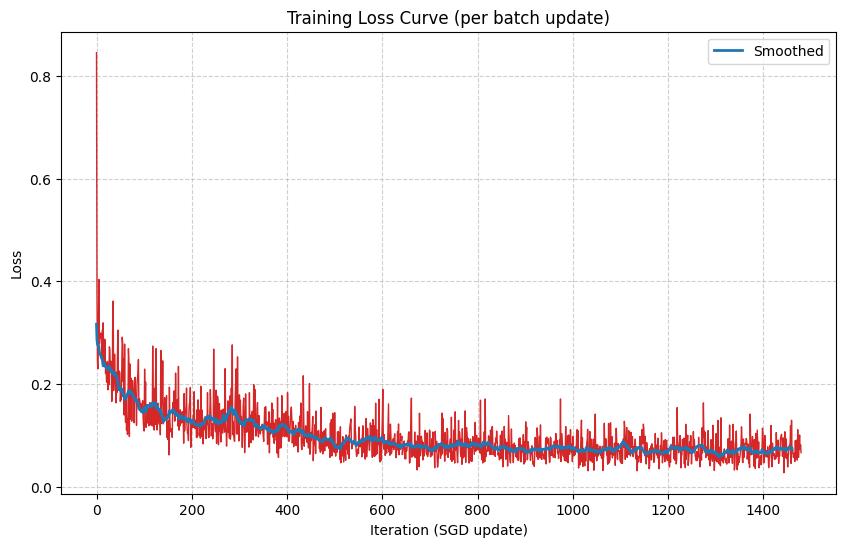

In [18]:
# Training loop
NUM_EPOCHS = 10
train_loss_history = []

for epoch in tqdm(range(NUM_EPOCHS)):
      model.train()
      running_loss = 0.0

      for i, (images, targets) in enumerate(loader_train):
          images = [img.to(device) for img in images]
          targets = [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          loss_val = losses.detach().item()
          train_loss_history.append(loss_val)
          running_loss += loss_val

          if (i + 1) % 10 == 0:
              avg_loss = running_loss / (i + 1)
              print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Step {i+1}/{len(loader_train)} | Avg loss: {avg_loss:.4f}")

      lr_scheduler.step()

print("Training done.")


# Courbe de loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, color='tab:red', linewidth=1)
plt.title("Training Loss Curve (per batch update)")
plt.xlabel("Iteration (SGD update)")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.6)

if len(train_loss_history) > 20:
    smooth_loss = np.convolve(train_loss_history, np.ones(20)/20, mode='valid')
    plt.plot(smooth_loss, color='tab:blue', linewidth=2, label='Smoothed')
    plt.legend()

plt.show()


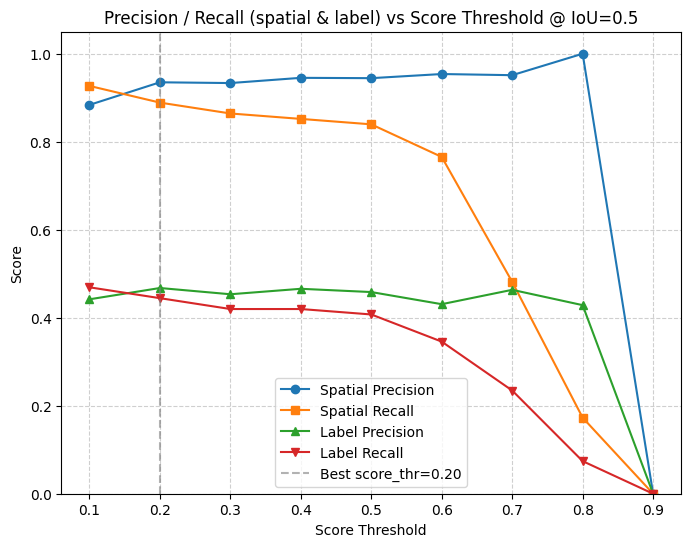

IoU fixe : 0.5
Score threshold optimal (labels) : 0.20
Spatial Precision : 0.935 | Spatial Recall : 0.889
Label Precision   : 0.468 | Label Recall   : 0.444


In [ ]:
def prf_curve_score(model, loader, score_thresholds=np.linspace(0.1, 0.9, 9), iou_thr=0.5, nms_iou=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    spatial_precisions, spatial_recalls = [], []
    label_precisions, label_recalls = [], []

    with torch.no_grad():
        for score_thr in score_thresholds:
            TP_spatial, FP_spatial, FN_spatial = 0, 0, 0
            TP_label, FP_label, FN_label = 0, 0, 0

            for imgs, targets in loader:
                imgs = [img.to(device) for img in imgs]
                preds = model(imgs)

                for pred, target in zip(preds, targets):
                    gt_boxes = target["boxes"].to(device)
                    gt_labels = target["labels"].to(device)

                    boxes = pred["boxes"].to(device)
                    scores = pred["scores"].to(device)
                    labels = pred["labels"].to(device)

                    if boxes.numel() == 0 and gt_boxes.numel() == 0:
                        continue

                    if boxes.numel() == 0:
                        FN_spatial += len(gt_boxes)
                        FN_label += len(gt_boxes)
                        continue

                    keep_nms = nms(boxes, scores, nms_iou)
                    boxes = boxes[keep_nms]
                    scores = scores[keep_nms]
                    labels = labels[keep_nms]

                    keep = scores > score_thr
                    boxes = boxes[keep]
                    labels = labels[keep]

                    if gt_boxes.numel() == 0:
                        FP_spatial += len(boxes)
                        FP_label += len(boxes)
                        continue

                    ious = box_iou(boxes, gt_boxes)
                    max_iou, idx_gt = ious.max(dim=1)

                    TP_spatial_i = (max_iou >= iou_thr).sum().item()
                    FP_spatial_i = (max_iou < iou_thr).sum().item()
                    FN_spatial_i = max(len(gt_boxes) - TP_spatial_i, 0)
                    TP_spatial += TP_spatial_i
                    FP_spatial += FP_spatial_i
                    FN_spatial += FN_spatial_i

                    correct_labels = ((max_iou >= iou_thr) & (labels == gt_labels[idx_gt])).sum().item()
                    wrong_labels = ((max_iou >= iou_thr) & (labels != gt_labels[idx_gt])).sum().item()
                    missed_labels = max(len(gt_boxes) - correct_labels, 0)
                    TP_label += correct_labels
                    FP_label += wrong_labels + FP_spatial_i
                    FN_label += missed_labels

            spatial_precision = TP_spatial / max((TP_spatial + FP_spatial), 1e-6)
            spatial_recall = TP_spatial / max((TP_spatial + FN_spatial), 1e-6)
            label_precision = TP_label / max((TP_label + FP_label), 1e-6)
            label_recall = TP_label / max((TP_label + FN_label), 1e-6)

            spatial_precisions.append(spatial_precision)
            spatial_recalls.append(spatial_recall)
            label_precisions.append(label_precision)
            label_recalls.append(label_recall)

    return (np.array(score_thresholds),
            np.array(spatial_precisions), np.array(spatial_recalls),
            np.array(label_precisions), np.array(label_recalls))


score_vals, sp_prec, sp_rec, lb_prec, lb_rec = prf_curve_score(model, loader_test, iou_thr=0.5)

f1_spatial = 2 * (sp_prec * sp_rec) / np.maximum(sp_prec + sp_rec, 1e-6)
f1_label = 2 * (lb_prec * lb_rec) / np.maximum(lb_prec + lb_rec, 1e-6)

best_idx = np.argmax(f1_label)
best_score = score_vals[best_idx]

plt.figure(figsize=(8, 6))
plt.plot(score_vals, sp_prec, marker='o', label='Spatial Precision', color='tab:blue')
plt.plot(score_vals, sp_rec, marker='s', label='Spatial Recall', color='tab:orange')
plt.plot(score_vals, lb_prec, marker='^', label='Label Precision', color='tab:green')
plt.plot(score_vals, lb_rec, marker='v', label='Label Recall', color='tab:red')
plt.axvline(best_score, color='gray', linestyle='--', alpha=0.6, label=f'Best score_thr={best_score:.2f}')
plt.title("Precision / Recall (spatial & label) vs Score Threshold @ IoU=0.5")
plt.xlabel("Score Threshold")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print(f"IoU fixe : 0.5")
print(f"Score threshold optimal (labels) : {best_score:.2f}")
print(f"Spatial Precision : {sp_prec[best_idx]:.3f} | Spatial Recall : {sp_rec[best_idx]:.3f}")
print(f"Label Precision   : {lb_prec[best_idx]:.3f} | Label Recall   : {lb_rec[best_idx]:.3f}")


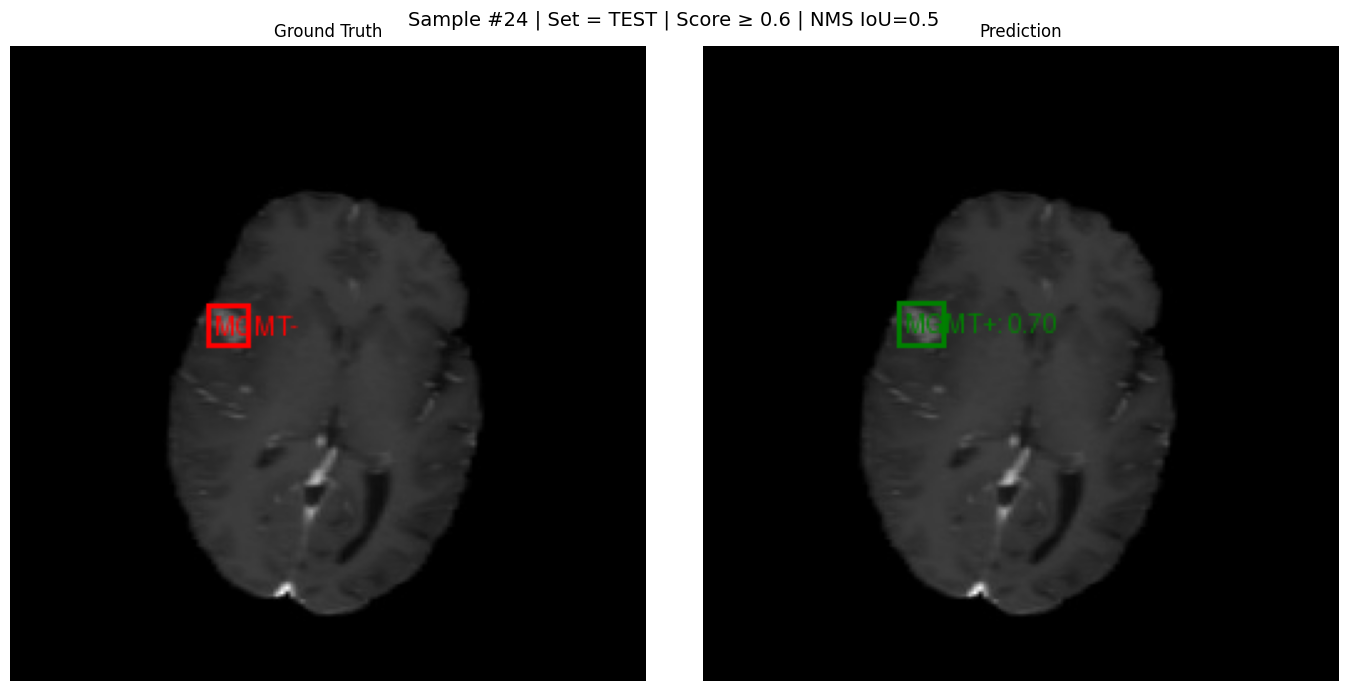

In [ ]:
def visualize_prediction(sample_idx: int = 11, score_thr: float = 0.5, from_test: bool = True, nms_iou: float = 0.5):
    ds = dataset_test if from_test else dataset_train
    img, target = ds[sample_idx]

    raw_img = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
    raw_img = raw_img[:3, ...]

    color_map = {1: "red", 2: "green"}

    gt_boxes = target["boxes"].to(torch.int64)
    gt_labels = target["labels"]
    gt_texts = [f"{CLASS_NAMES[int(l)]}" for l in gt_labels]
    gt_colors = [color_map.get(int(l), "blue") for l in gt_labels]
    gt_img = draw_bounding_boxes(raw_img, gt_boxes, gt_texts, colors=gt_colors, width=2)

    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)])[0]

    boxes = pred["boxes"].to("cpu")
    scores = pred["scores"].to("cpu")
    labels = pred["labels"].to("cpu")

    keep_nms = nms(boxes, scores, nms_iou)
    boxes = boxes[keep_nms]
    scores = scores[keep_nms]
    labels = labels[keep_nms]

    keep = scores >= score_thr
    pred_boxes = boxes[keep].to(torch.int64)
    pred_labels = labels[keep]
    pred_scores = scores[keep]

    pred_texts = [f"{CLASS_NAMES[int(l)]}: {float(s):.2f}" for l, s in zip(pred_labels, pred_scores)]
    pred_colors = [color_map.get(int(l), "blue") for l in pred_labels]
    pred_img = draw_bounding_boxes(raw_img, pred_boxes, pred_texts, colors=pred_colors, width=2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    fig.suptitle(f"Sample #{sample_idx} | Set = {'TEST' if from_test else 'TRAIN'} | Score ≥ {score_thr} | NMS IoU={nms_iou}", fontsize=14)

    axes[0].imshow(gt_img.permute(1, 2, 0))
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    axes[1].imshow(pred_img.permute(1, 2, 0))
    axes[1].set_title("Prediction")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_prediction(sample_idx=24, score_thr=0.6, from_test=True)
